<a href="https://colab.research.google.com/github/maxogod/ETL/blob/main/BDD_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Base de Datos ~ Merlino </center>

## <center> Trabajo Practico: ETL </center>

## Integrantes:

* Maximo Damian Utrera - 109651 - mutrera@fi.uba.ar
* Agustín Barbalase - 109071 - abarbalase@fi.uba.ar
* Santiago Sevitz - 107520 - ssevitz@fi.uba.ar
* Nicolas Ramiro Sanchez - 98792 - nrsanchez@fi.uba.ar
* Jimmy Guertin - 2132273 (Intercambio) - jimmy.guertin@student-cs.fr
* Jonatan Enrique Gomez Godoy - 91629 - jegomezg@fi.uba.ar

## Imports

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import sqlite3

import warnings
warnings.filterwarnings("ignore")

## Importacion de dataset

### Google drive

In [205]:
from google.colab import drive
drive.mount('/content/drive')
root_path = "/content/drive/MyDrive/BDD-TP/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Local

Si se trabaja en local, comentar la celda de arriba y descomentar la de abajo.

In [206]:
# root_path = './'

In [207]:
file_path = root_path + 'Dataset/real_estate.csv'
df = pd.read_csv(file_path)

## Exploracion inicial

Se observa la forma de los datos a trabajar

In [208]:
df.shape

(1054159, 11)

Ahora se ven que columnas tenemos en el dataset

In [209]:
df.dtypes

Date Recorded        object
List Year             int64
Town                 object
Address              object
Assessed Value      float64
Sale Amount         float64
Sales Ratio         float64
Property Type        object
Residential Type     object
Longitude           float64
Latitude            float64
dtype: object

Visualizacion rapida de las primeras lineas

In [210]:
df.head()

,Date Recorded,List Year,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Longitude,Latitude
0,2021-04-14,2020,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,-73.06822,41.35014
1,2021-05-26,2020,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN
2,2021-09-13,2020,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN
3,2020-12-14,2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN
4,2021-09-07,2020,Avon,245 NEW ROAD,217640.0,400000.0,0.5441,Residential,Single Family,NaN,NaN


Vemos metricas a modo de resumen del dataset.

In [211]:
ds_resumen = df.describe()
ds_resumen

,List Year,Assessed Value,Sale Amount,Sales Ratio,Longitude,Latitude
count,1.054159e+06,1.054159e+06,1.054159e+06,1.054159e+06,254643.000000,254643.000000
mean,2.010774e+03,2.797416e+05,3.990286e+05,9.953241e+00,-72.878565,41.499377
std,6.540711e+00,1.650117e+06,5.229758e+06,1.838434e+03,0.446531,0.258100
min,2.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-121.230910,34.345810
25%,2.004000e+03,8.845000e+04,1.422000e+05,4.816008e-01,-73.198040,41.292266
50%,2.011000e+03,1.395800e+05,2.300000e+05,6.162887e-01,-72.900600,41.504259
75%,2.017000e+03,2.270000e+05,3.700000e+05,7.764000e-01,-72.633226,41.714357
max,2.021000e+03,8.815100e+08,5.000000e+09,1.226420e+06,-71.187550,44.934590


Visualizacion de que tipos de property types hay

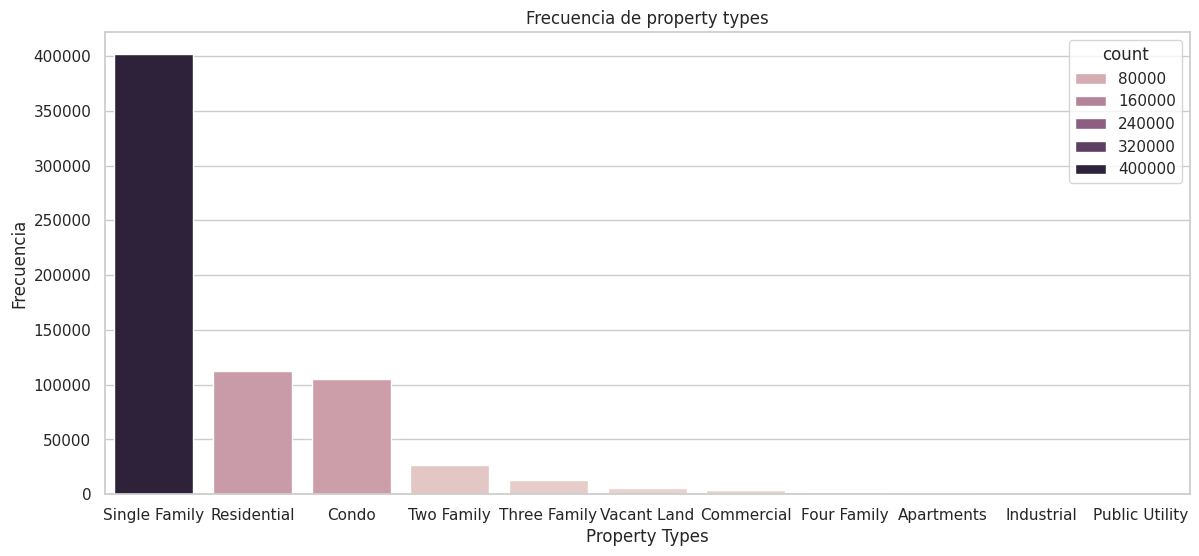

In [212]:
plot = df["Property Type"].value_counts()
plt.figure(figsize=(14, 6))
sns.barplot(x=plot.index, y=plot.values, hue=plot)
plt.xlabel("Property Types")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de property types")
plt.show()

Visualizacion de los residential types

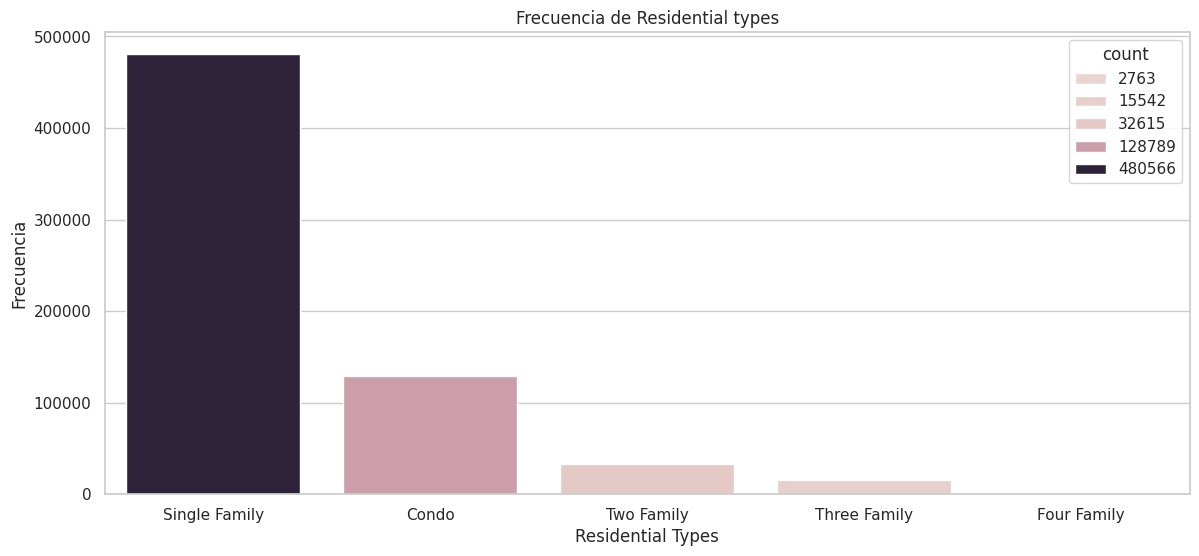

In [213]:
plot = df["Residential Type"].value_counts()
plt.figure(figsize=(14, 6))
sns.barplot(x=plot.index, y=plot.values, hue=plot)
plt.xlabel("Residential Types")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Residential types")
plt.show()

Como se puede ver hay valores propios de residential type dentro de property types, esto se analizara y se decidira que hacer con dichas columnas en la seccion de validacion de integridad de los datos.

Las ciudades que aparecen en el dataset son las siguientes

In [214]:
df['Town'].value_counts()

Town
Bridgeport       36486
Stamford         34994
Waterbury        30891
Norwalk          25681
New Haven        22721
                 ...  
Hartland           487
Canaan             474
Scotland           463
Union              287
***Unknown***        1
Name: count, Length: 170, dtype: int64

Se ve que hay una ciudad catalogada como ***Unknown*** la eliminamos

In [215]:
df = df.drop(df[df['Town'] == '***Unknown***'].index)

Se observa si hay direcciones repetidas, lo cual indicaria que hay varios inmuebles que se venden mas de una vez. Esto no significa que si o si son registros duplicados, los realmente duplicados los veremos en su respectiva seccion.

Se observa si hay direcciones repetidos, lo cual indicaria que hay varios inmuebles que se venden mas de una vez.

In [216]:
df['Address'].nunique() # Direcciones unicas

747237

In [217]:
address_counts = df.groupby('Address').size()
addresses_with_more_than_one = address_counts[address_counts > 1]
addresses_with_more_than_one

Address
0  PINE POINT RD                 4
0 & 12 JOHNSON ST                4
0 5 & 7 DOGWOOD CT               2
0 ALLYN ST LOT 4 & 0 ALLYN ST    2
0 ALUMNI ROAD                    2
                                ..
ZACCHEUS MEAD LN                 4
ZAICEK RD                        2
ZEIGLER RD                       2
ZOAR ST & VILLA AVE              2
ZURKO FARM RD                    6
Length: 197248, dtype: int64

Visualizamos el rango de precios general de todos los inmuebles.

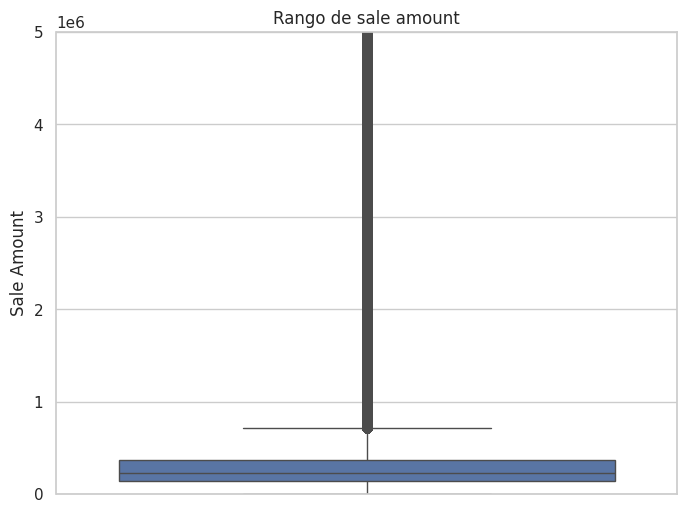

In [218]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='Sale Amount')
plt.title('Rango de sale amount')
plt.ylabel('Sale Amount')
plt.ylim(0, 5_000_000)
plt.show()

Aca se pueden observar que hay bastantes valores atipicos que abordaremos en dicha seccion.

Pareciera que latitud y longitud no tienen muchos valores no nulos

In [219]:
df["Latitude"].isna().value_counts()

Latitude
True     799515
False    254643
Name: count, dtype: int64

In [220]:
df["Longitude"].isna().value_counts()

Longitude
True     799515
False    254643
Name: count, dtype: int64

En efecto la gran mayoria de sus datos son nulos, se tomara una decision sobre estos en la siguiente seccion.

## Datos Nulos o Faltantes

Primero veo los datos faltantes de cada columna en general

In [221]:
def print_datos_nulos(ds, feature):
  print(df[feature].isna().value_counts())

In [222]:
for col in df.columns:
  print_datos_nulos(df, col)

Date Recorded
False    1054156
True           2
Name: count, dtype: int64
List Year
False    1054158
Name: count, dtype: int64
Town
False    1054158
Name: count, dtype: int64
Address
False    1054107
True          51
Name: count, dtype: int64
Assessed Value
False    1054158
Name: count, dtype: int64
Sale Amount
False    1054158
Name: count, dtype: int64
Sales Ratio
False    1054158
Name: count, dtype: int64
Property Type
False    671712
True     382446
Name: count, dtype: int64
Residential Type
False    660274
True     393884
Name: count, dtype: int64
Longitude
True     799515
False    254643
Name: count, dtype: int64
Latitude
True     799515
False    254643
Name: count, dtype: int64


Al ser tan pocos los nulos de las columnas:

* Date
* Address

Vamos a eliminar dichos registros.

A su vez al ser tantos nulos (la gran mayoria) eliminaremos las columnas Latitude y Longitude.

In [223]:
# Sera usada en la seccion de transformacion de dataset
def eliminar_nulos(ds):
  cols_a_eliminar = ['Latitude', 'Longitude']
  nulos_a_eliminar = ['Date Recorded', 'Address']
  ds.drop(columns=cols_a_eliminar, inplace=True)
  ds.dropna(subset=nulos_a_eliminar)

Se decidio que residential type y property type a pesar de tener una amplia cantidad de nulos se conservaran y se analizara su integridad mas adelante.

## Datos Fuera de Rango y atipicos


En esta sección de código se implementó las funciones necesarias para aplicar un flitro sobre la información del dataset, donde se quitan registros que se consideran fuera de rango, utilizando la metrica de z-score, y utilizando un umbral de referencia de valor absoluto 3 (que esté entre -3 y +3), ademas de ciertos datos analizados personalmente que se consideran un pre-filtro de la información innecesaria, específicamente que el valor de la propiedad sea mayor a 0.

In [224]:
def crear_boxplots(ds, columnas):
    sns.set(style="whitegrid")

    for columna in columnas:
        plt.figure(figsize=(8, 4))
        sns.boxplot(y=ds[columna])
        sns.boxplot(palette='viridis')
        plt.title(f'Boxplot de {columna}')
        plt.ylabel(columna)
        plt.show()

def filtrar_atipicos(ds, umbral_zscore=3):
    # Filtrar negativos
    ds = ds[(ds['Sale Amount'] > 0) & (ds['Assessed Value'] > 0)]

    # Calcular el Z-score
    ds['Sale Amount Z-score'] = zscore(ds['Sale Amount'])
    ds['Assessed Value Z-score'] = zscore(ds['Assessed Value'])

    # Filtrar los outliers usando el Z-score
    ds = ds[(ds['Sale Amount Z-score'].abs() <= umbral_zscore) &
                              (ds['Assessed Value Z-score'].abs() <= umbral_zscore)]

    ds.drop(columns=['Sale Amount Z-score', 'Assessed Value Z-score'], inplace=True)
    return ds

Primero se aplica un analisis de datos sin filtrar, se espera que sea una visualización mediante boxplots de manera desprolija e inentendible (debido a la presencia de valores atipicos), a diferencia de la información ya filtrada proximamente:

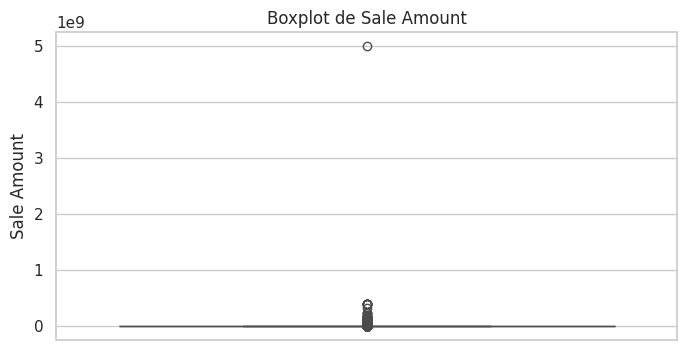

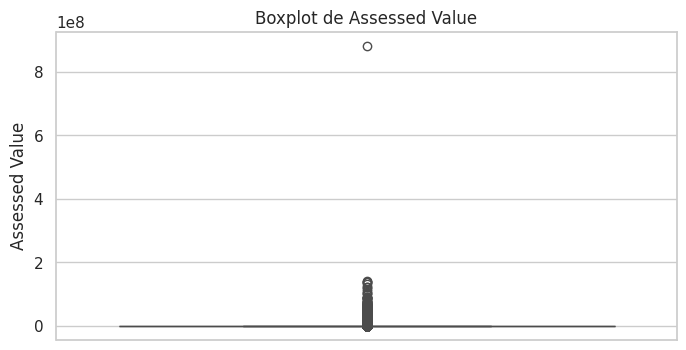

In [225]:
datosFDR_ds = df.copy()
columnas = ['Sale Amount', 'Assessed Value']
crear_boxplots(datosFDR_ds, columnas)

Ahora se aplica el filtro a la base de datos explicado previamente en las declaraciones de las funciones.

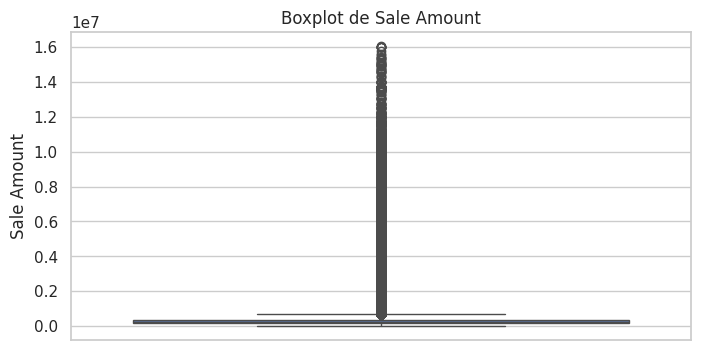

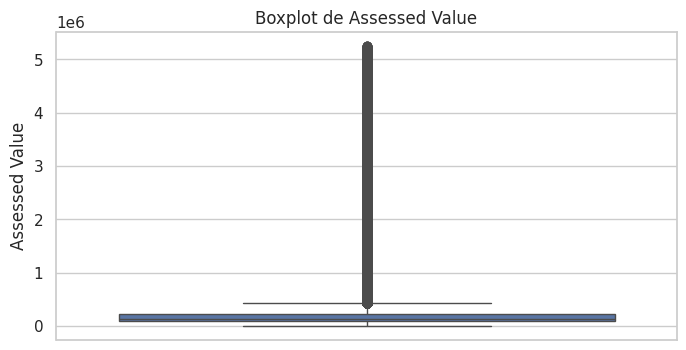

In [226]:
datosFDR_ds = filtrar_atipicos(datosFDR_ds)
crear_boxplots(datosFDR_ds, columnas)

## Inconsistencias de Formatos


In [227]:
def transformar_formatos(ds):
  # Convirtiendo 'Date Recorded' al formato de fecha
  ds['Date Recorded'] = pd.to_datetime(ds['Date Recorded'], errors='coerce')

  # Transformar 'Town' de object a string
  ds['Town'] = ds['Town'].astype(str)

  # Transformar 'Property Type' de object a string
  ds['Property Type'] = ds['Property Type'].astype(str)

  # Transformar 'Residential Type' de object a string
  ds['Residential Type'] = ds['Residential Type'].astype(str)

## Datos Duplicados

In [228]:
duplicates = df[df.duplicated(keep=False)]

# muestra todas las filas duplicadas que estan en la dataset
duplicates.head()

,Date Recorded,List Year,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Longitude,Latitude
217,2021-02-25,2020,Shelton,197 BEARDSLEY RD,132440.0,875000.0,0.151300,Vacant Land,NaN,NaN,NaN
393,2021-01-05,2020,Litchfield,43 NORFOLK RD,163640.0,75000.0,2.181800,Residential,Single Family,-73.19135,41.75989
671,2020-11-16,2020,Burlington,25 SUMMIT DRIVE,112980.0,191000.0,0.591518,Residential,Single Family,NaN,NaN
846,2021-01-13,2020,Guilford,312 OLD WHITFIELD ST,188520.0,161500.0,1.167300,Residential,Single Family,NaN,NaN
1014,2020-10-20,2020,Bethel,8 BROOKWOOD DRIVE,155680.0,305200.0,0.510000,Residential,Single Family,-73.40019,41.37792


In [229]:
# Resumen de cantidad de filas duplicadas
duplicate_counts = df.duplicated(keep=False).sum()
print(f"Numero de filas duplicadas: [{duplicate_counts}]")

Numero de filas duplicadas: [16725]


Como podemos ver, la cantidad de filas duplicadas es menos del 2% de nuestro conjunto de datos, que tiene 1,054,159 filas. Eliminar estos duplicados no afectará negativamente la base de datos.

A continuación, crearé una función que se utilizará más adelante para eliminar todos los datos duplicados del conjunto de datos.

In [230]:
def quitar_duplicados(df):
    df.drop_duplicates()

## Transformacion del Dataset

A continuación, aplicaremos modificaciones al conjunto de datos para eliminar información irrelevante, inválida, inconsistente, nula y duplicada.

In [231]:
# Eliminacion de datos nulos
eliminar_nulos(df)

# Eliminacion de datos fuera de rango
df = filtrar_atipicos(df)

# Transformar formatos
transformar_formatos(df)

# Eliminacion de datos duplicados
quitar_duplicados(df)

'''
Luego de un analisis de la columna [Sales Ratio], descubrimos que es un campo
calculado que consiste en:
Assessed Value / Sale Amount = Sales Ratio
Como esta info es facilmente obtenible a traves de una Query, no es necesario
guardar esta columna en la base de datos. Por lo tanto hemos decidido descartar
esta columna
'''
df.drop(columns=['Sales Ratio'], inplace=True)

A continuacion se hara el manejo de la incongruencia entre property type y residential type mencionada en la exploracion inicial.

Cambiaremos todos los property types que tengan alguno de los siguientes valores:

* Single Family
* Condo
* Two Family
* Three Family
* Four Family

a **Residential** y le asignaremos lo que tenia antes a su residential type.

In [232]:
def transformar_incongruencias(ds, value):
  if ds[ds['Property Type'] == value].empty: return
  ds.loc[ds['Property Type'] == value, 'Residential Type'] = value
  ds.loc[ds['Property Type'] == value, 'Property Type'] = 'Residential'

transformar_incongruencias(df, 'Single Family')
transformar_incongruencias(df, 'Two Family')
transformar_incongruencias(df, 'Three Family')
transformar_incongruencias(df, 'Four Family')
transformar_incongruencias(df, 'Condo')

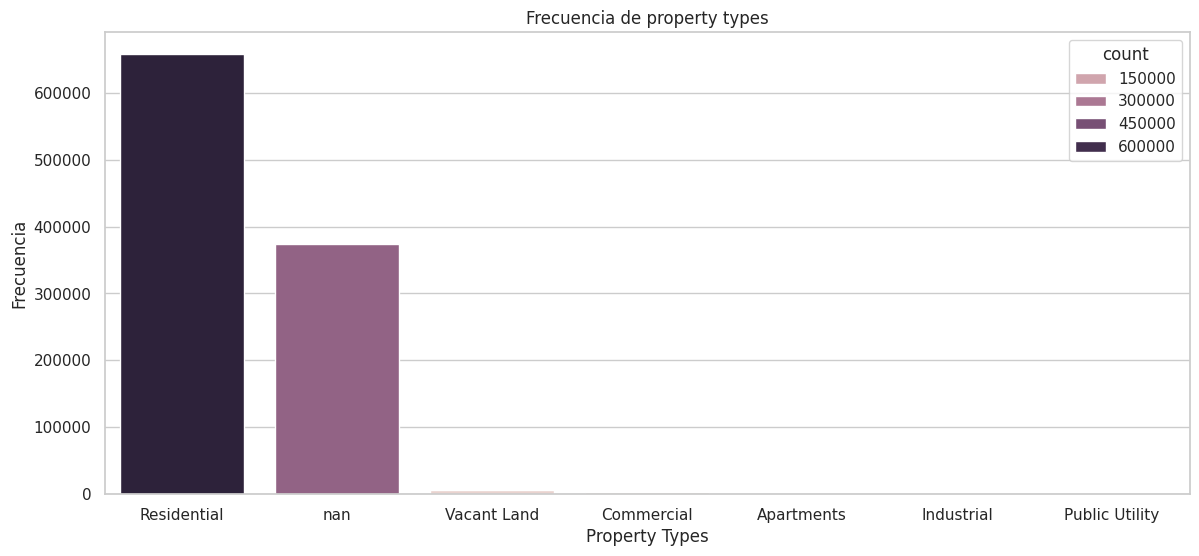

In [233]:
plot = df["Property Type"].value_counts()
plt.figure(figsize=(14, 6))
sns.barplot(x=plot.index, y=plot.values, hue=plot)
plt.xlabel("Property Types")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de property types")
plt.show()

Como casi todas las property types que estan definidas son **residential** procedemos a dropear dicha columna y solo quedarnos con residential type

In [234]:
df.drop(columns=['Property Type'], inplace=True)

Vemos el nuevo shape del dataset

In [235]:
df.shape

(1041780, 7)

Renombramos las columnas para quitar espacios:

In [236]:
df.rename(columns={'Date Recorded': 'date_recorded'}, inplace=True)
df.rename(columns={'List Year': 'list_year'}, inplace=True)
df.rename(columns={'Town': 'town'}, inplace=True)
df.rename(columns={'Address': 'address'}, inplace=True)
df.rename(columns={'Assessed Value': 'assessed_value'}, inplace=True)
df.rename(columns={'Sale Amount': 'sale_amount'}, inplace=True)
df.rename(columns={'Residential Type': 'residential_type'}, inplace=True)

In [237]:
df.dtypes

date_recorded       datetime64[ns]
list_year                    int64
town                        object
address                     object
assessed_value             float64
sale_amount                float64
residential_type            object
dtype: object

## Validacion de Integridad de los Datos

Antes del análisis, realizamos una exploración inicial para revisar la información relevante del conjunto de datos, incluyendo la cantidad de columnas y filas, el tipo de columnas y la identificación de la información más importante para almacenar en la base de datos.

Luego de la exploracion inicial, analizamos lo siguiente:

**1. Analisis de datos Nulos:**

*En esta seccion se analizan los datos nulos para tomar una decision en base a estos. La decision tomada fue eliminar las columnas de Latitud y longitud ya que eran casi 100% nulas y a su vez eliminar los registros con fechas y direcciones nulas ya que eran unos pocos.*

**2. Analisis de datos fuera de rango (outliars):**

    [AGREGAR RESUMEN PROPIO]

**3. Inconsistencia de formatos:**

*El código realiza las siguientes transformaciones en un DataFrame:*

- *Convierte la columna 'Date Recorded' a formato de fecha: Utiliza pd.to_datetime para transformar los valores de esta columna en datos de tipo datetime, manejando errores con coerce para reemplazar valores no convertibles con NaT (Not a Time).*

- *Convierte la columna 'Town' a tipo string: Asegura que todos los valores en la columna 'Town' sean de tipo string.*
*Convierte la columna 'Property Type' a tipo string: Asegura que todos los valores en la columna 'Property Type' sean de tipo string.*

- *Convierte la columna 'Residential Type' a tipo string: Asegura que todos los valores en la columna 'Residential Type' sean de tipo string.*

*Finalmente, la función transform_formats se aplica al DataFrame df y se verifican los tipos de datos de las columnas después de las transformaciones.*

**4. Datos duplicados:**

  *En esta sección, concluimos que el 2% de los valores del conjunto de datos son duplicados y los eliminamos, ya que mantener estos datos no aporta nada y su eliminación no perjudica la base de datos.*


*Además, observamos que la columna **Sales Ratio** es un campo calculado que se obtiene mediante el siguiente cálculo:*
**Assessed Value** / **Sale Amount** == **Sales Ratio**

*Como esta informacion se puede obtener a traves de una query, es redundante guardar esta columna en la base de datos*


## Carga a Base de Datos sin normalizar

In [238]:
conn = sqlite3.connect(root_path + 'Dataset/real_estate.sqlite3')
cursor = conn.cursor()

cursor.execute("""
    CREATE TABLE IF NOT EXISTS real_estate (
        date_recorded TEXT,
        list_year INTEGER,
        town TEXT,
        address TEXT,
        assessed_value REAL,
        sale_amount REAL,
        residential_type TEXT
    )
""")
conn.commit()

df.to_sql('real_estate', conn, if_exists='replace', index=False)
conn.commit()

conn.close()


### Verificacion de Base de Datos

Verificar que los datos han sido insertados correctamente y que la base de datos está en
un estado consistente.

## Normalizacion de base de datos (Boyce-Codd o NF3.5)

### Verificacion de Base de Datos

Verificar que los datos han sido insertados correctamente y que la base de datos está en
un estado consistente.